In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import  summary

import matplotlib.pyplot as plt

# Create data

In [21]:
n_gaus = 1000
img_size = 91

x= np.linspace(-4,4,img_size)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,n_gaus)

# initialize two tensor containing images
images_occ   = torch.zeros(n_gaus,1,img_size,img_size)
imgs_no_occ = torch.zeros(n_gaus,1,img_size,img_size)

for i in range(n_gaus):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # and add noise
  G  = G + np.random.randn(img_size,img_size)/5

  # add the original to the noocc
  imgs_no_occ[i,:,:,:] = torch.Tensor(G).view(1,img_size,img_size)


  # add a random bar randomly
  i1 = np.random.choice(np.arange(10,img_size-10))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # add to the tensor with occlusion
  images_occ[i,:,:,:] = torch.Tensor(G).view(1,img_size,img_size)

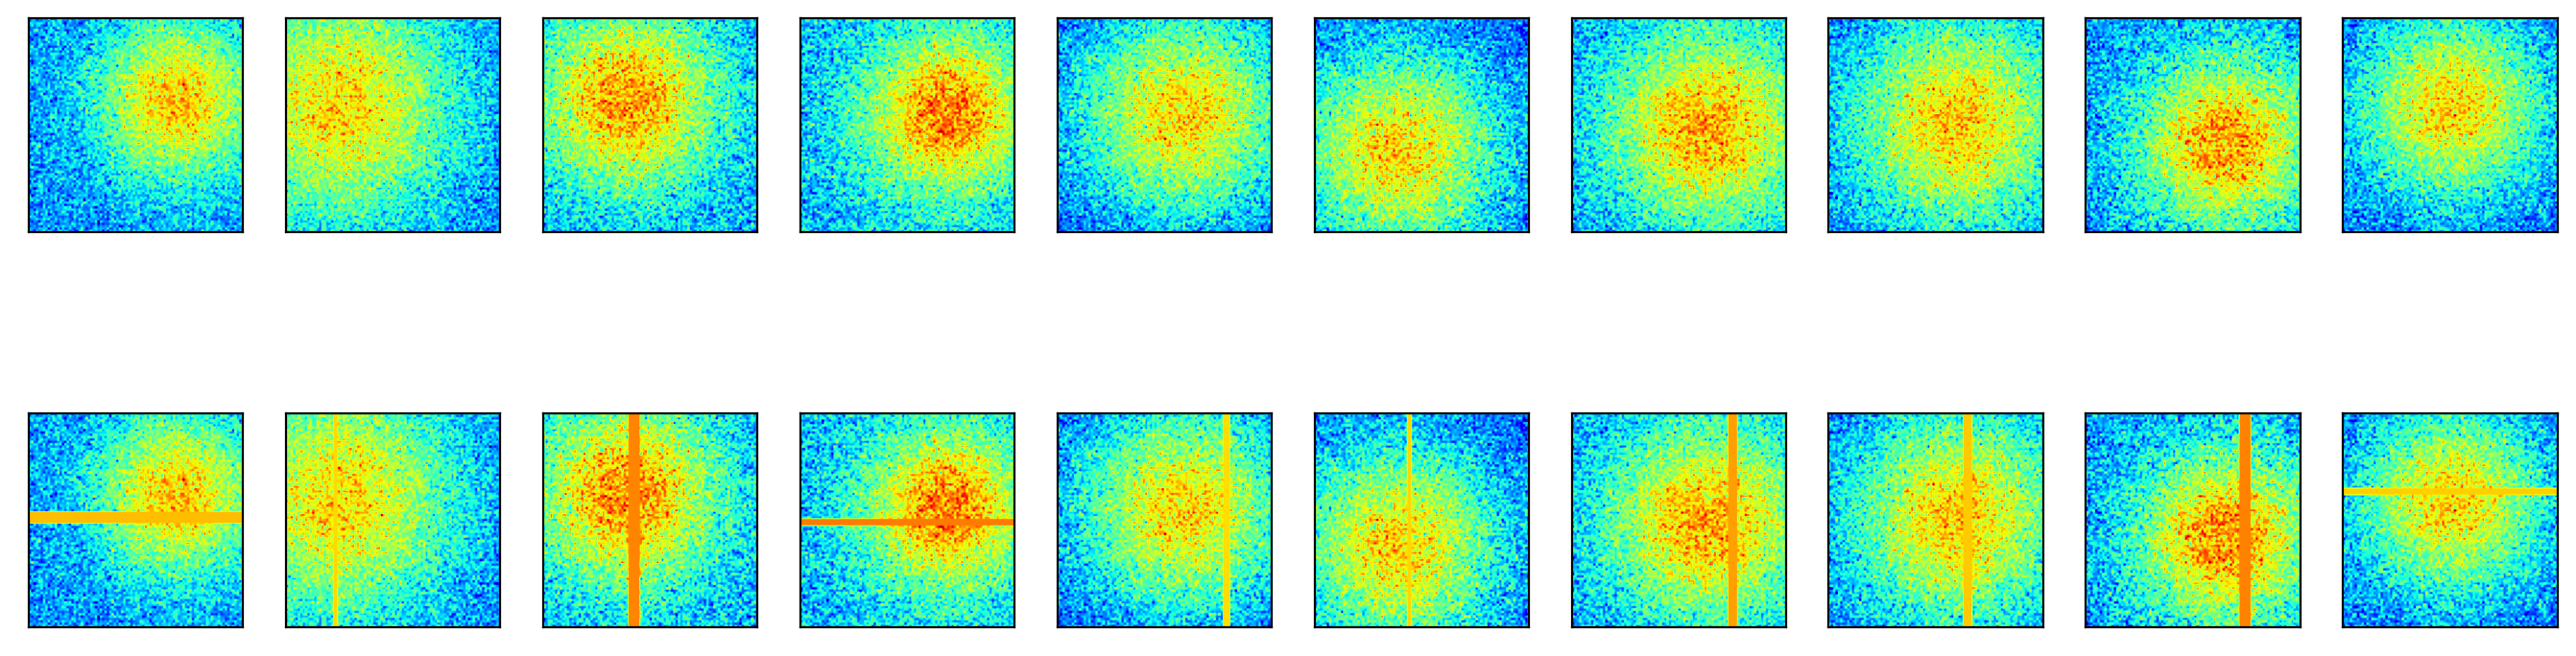

In [22]:
#visualize some images
fig,ax = plt.subplots(2,10,figsize=(17,5),dpi=200)

for i in range(10):
    which_pic = np.random.randint(n_gaus)
    ax[0,i].imshow(np.squeeze( imgs_no_occ[which_pic,:,:]),cmap='jet' )
    ax[0,i].set_xticks([]), ax[0,i].set_yticks([])

    ax[1,i].imshow(np.squeeze( images_occ[which_pic,:,:]), cmap='jet')
    ax[1,i].set_xticks([]),ax[1,i].set_yticks([])

plt.show()

# Create the AE

In [30]:
def make_the_net():

    class gaus_ae(nn.Module):
        def __init__(self):
            super().__init__()
            #create the encoder
            self.enc= nn.Sequential(
                nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),

                #second conv-activation-pool layer
                nn.Conv2d(in_channels=6,out_channels=4,kernel_size=3,stride=1,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )

            #decoder layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(in_channels=4,out_channels=6,kernel_size=3,stride=2),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=6,out_channels=1,kernel_size=3,stride=2)
                )

        def forward(self,x):
            return self.dec( self.enc(x) )

    #create a class instance
    net = gaus_ae()

    #loss function
    loss_fun = nn.MSELoss()

    #optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, loss_fun, optimizer

In [31]:
images_occ.shape

torch.Size([1000, 1, 91, 91])

 
torch.Size([10, 1, 91, 91])


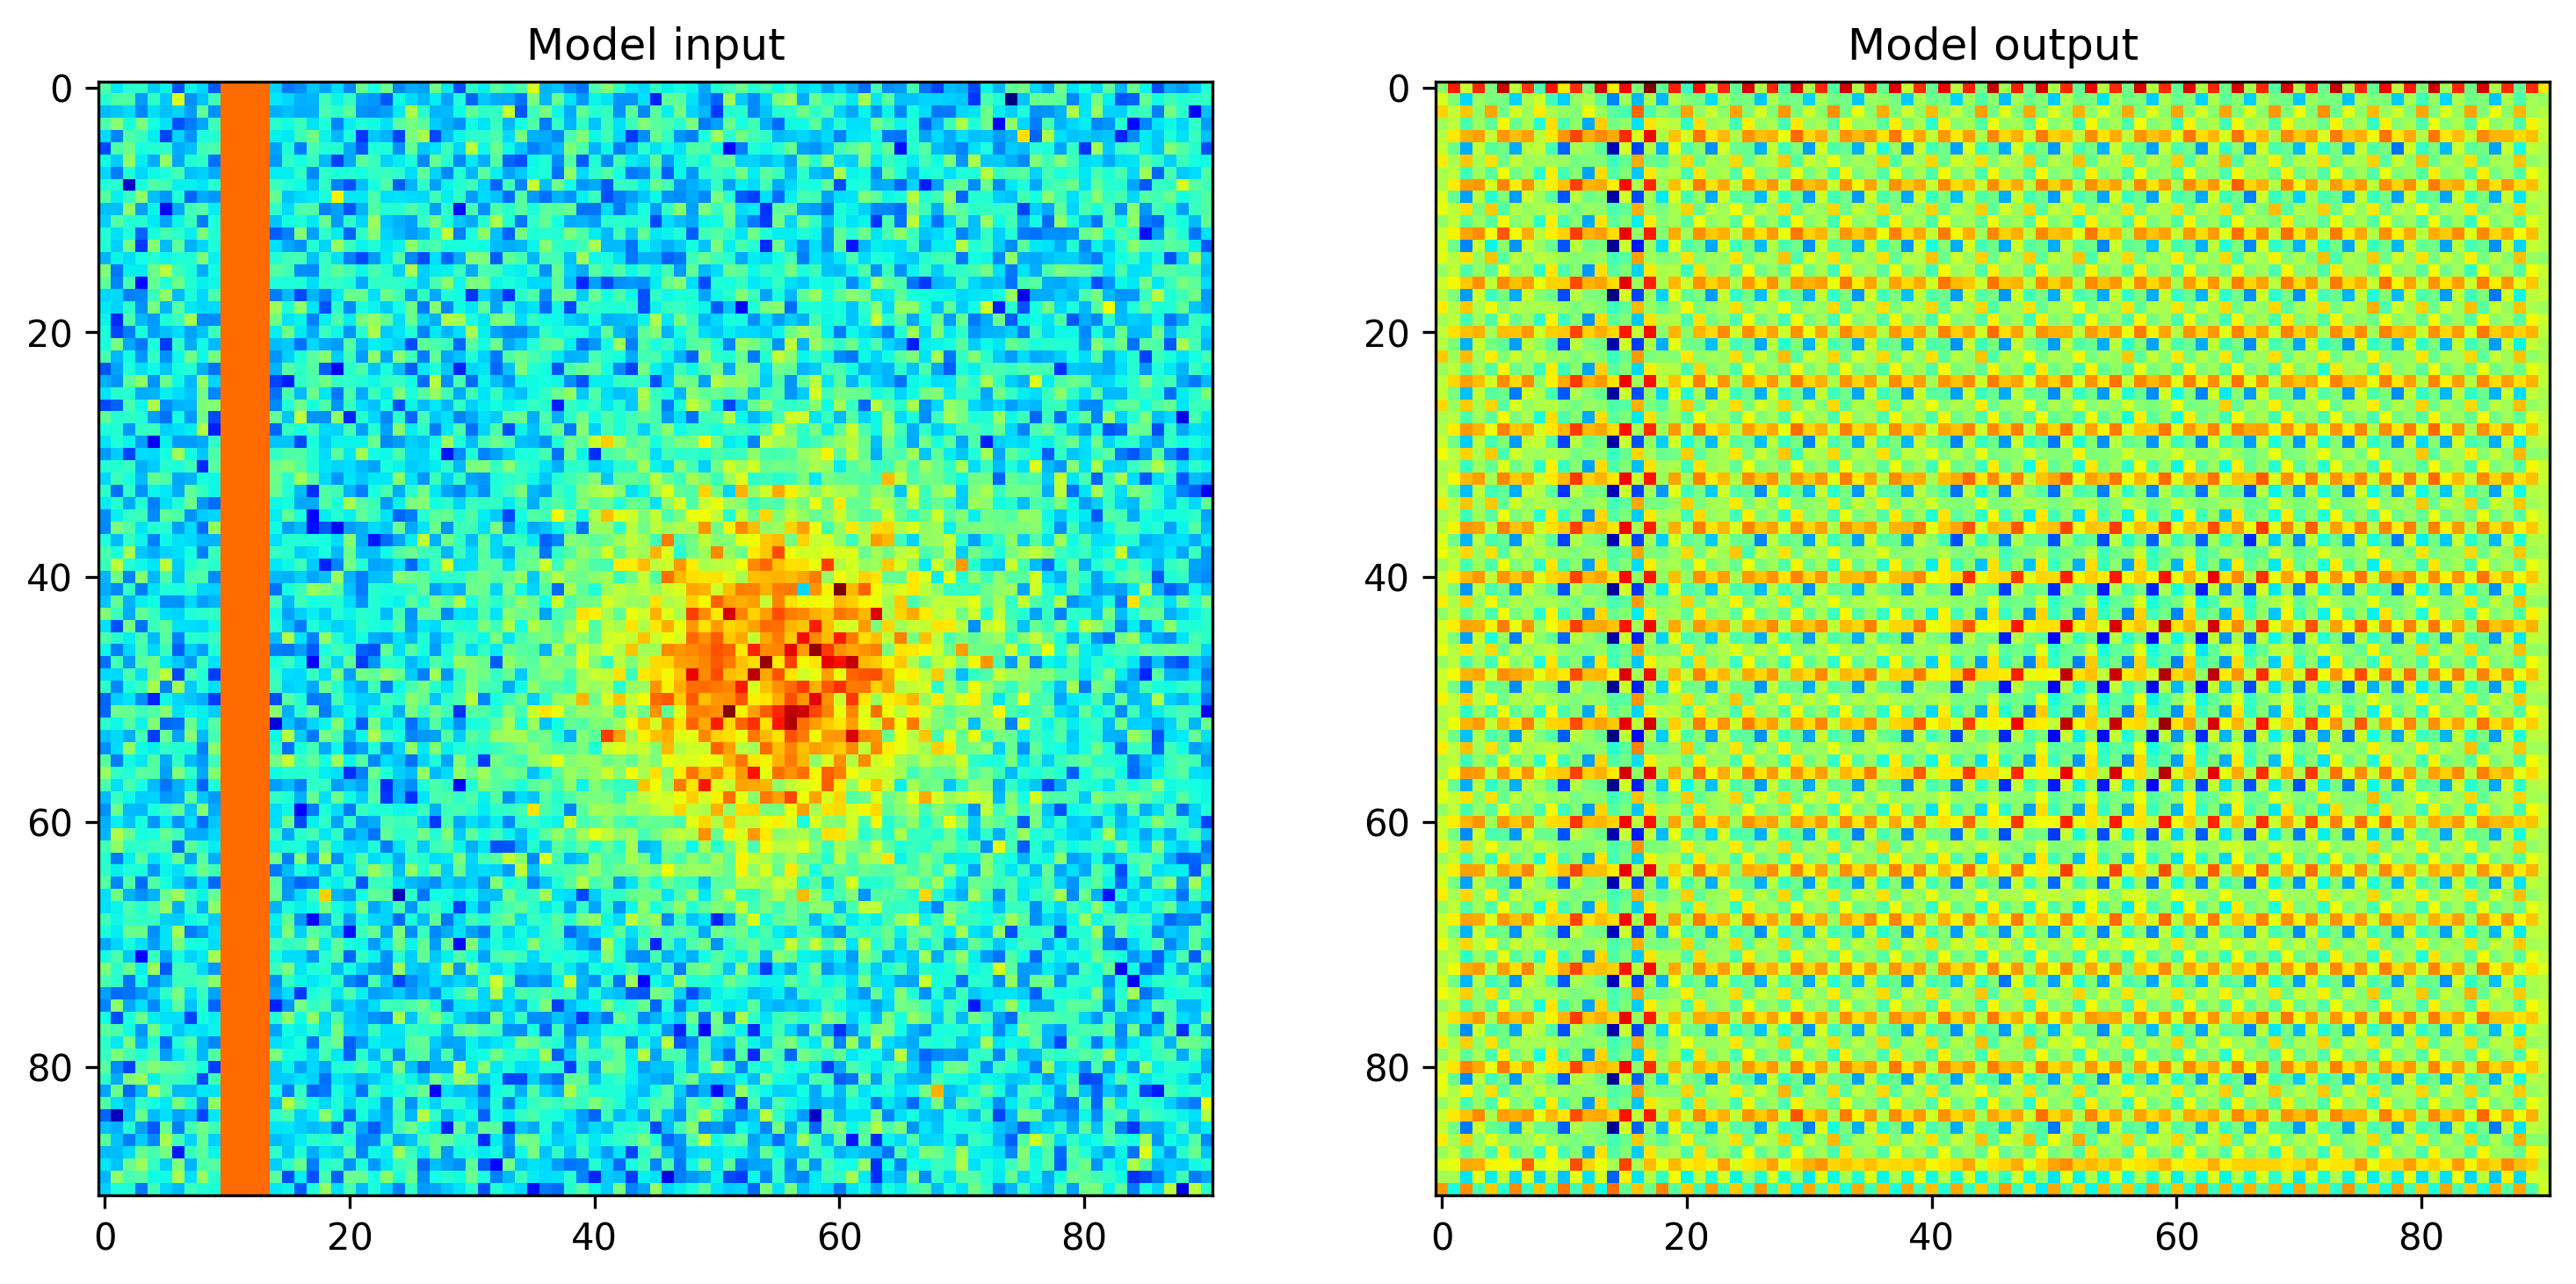

In [32]:
# sanity test
net,loss_fun,optimizer = make_the_net()

y_hat = net(images_occ[:10,:,:,:])

#check the size of output
print(' ')
print(y_hat.shape)

#let's see how theey look
fig,ax = plt.subplots(1,2,figsize=(12,8),dpi=300)
ax[0].imshow(torch.squeeze(images_occ[0,:,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(y_hat[0,:,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')
plt.show()

# Create a function that rains the model

In [33]:
imgs_no_occ.shape

torch.Size([1000, 1, 91, 91])

In [34]:
images_occ.shape

torch.Size([1000, 1, 91, 91])

In [35]:
# a function that trains the model

def function_to_train_model():
    n_epochs = 1000

    #create a new model
    net,loss_fun,optimizer = make_the_net()

    #initialize losses
    losses = torch.zeros(n_epochs)

    #loop over epochs
    for epochi in range(n_epochs):

        #pick a set of images at random
        pics_2_use = np.random.choice(n_gaus,size=32, replace=False)

        #get the input (has occlusion) and the target (no occlusion)
        X = images_occ[pics_2_use,:,:,:]
        Y = imgs_no_occ[pics_2_use,:,:,:]

        #forward pass and loss
        y_hat= net(X)
        loss = loss_fun(y_hat,Y)
        losses[epochi] = loss.item()

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #end epochs

    #function outpu
    return losses,net

# Run model and show result

In [36]:
losses,net = function_to_train_model()

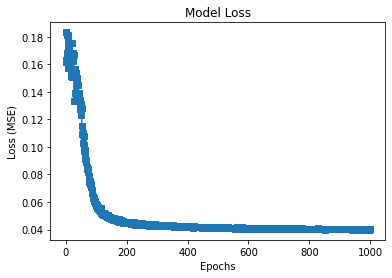

In [42]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')

plt.show();

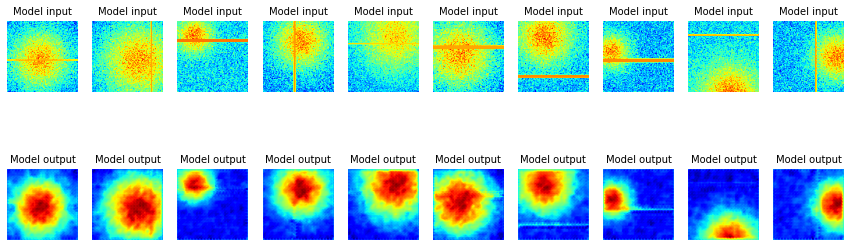

In [47]:
#visualize some images
pics_to_use = np.random.choice(n_gaus,size=32,replace=False)
X = images_occ[pics_to_use,:,:,:]
y_hat = net(X)

fig,ax = plt.subplots(2,10,figsize=(15,5))

for i in range(10):
    G =   torch.squeeze(X[i,:,:,:]).detach()
    O = torch.squeeze(y_hat[i,:,:,:]).detach()

    ax[0,i].imshow(G,cmap='jet')
    ax[0,i].axis('off')
    ax[0,i].set_title('Model input', fontsize=10)

    ax[1,i].imshow(O,cmap='jet')
    ax[1,i].axis('off')
    ax[1,i].set_title('Model output', fontsize=10)

plt.show()

# Thank you